Load models from iterations, train corresponding models on random data, and do comparison figures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, dump, load
from rdkit import Chem
from rdkit.Chem import AllChem
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import scipy

In [2]:
def rxn_dfp(rsmi):
    r, _, p = rsmi.split('>')
    rfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(r), 4, useChirality=True)
    pfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(p), 4, useChirality=True)
    return np.array(pfp) - np.array(rfp)

In [3]:
plt.rcParams.update({"font.size":9})
custom_palette = ['#005EB8', '#C4476E', '#008C95', '#4F5199', "#B0B0B0"]
sns.set_palette(palette=custom_palette)

In [29]:
target = "CAD Yield (%)"
df_exp = pd.read_csv("../data/experimental_results_final.csv", index_col=0).dropna(subset=[target])
f_cols = [col for col in df_exp.columns if col.startswith('f_')]
print(df_exp.shape)
print(len(f_cols))

(1291, 2148)
2135


/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
df_exp["selection"].value_counts()

active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
unexplored                  90
high_yield                  87
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               40
test_3                      32
cross_active_learning       30
cross_random                14
Name: selection, dtype: int64

In [31]:
df_core1_random = df_exp[df_exp["selection"].isin(["random_1", "random_2", "random_3", "random_4", "test_1", "test_2", "test_3"])]
(df_core1_random[target] > 10).value_counts()

False    454
True     101
Name: CAD Yield (%), dtype: int64

In [32]:
df_test_core1 = df_exp[df_exp["selection"].isin(["test_1", "test_2", "test_3"])]
df_test_core2 = df_exp[df_exp["selection"].isin(["cores2_test_1", "cores2_test_2"])]
df_r1 = df_exp[df_exp["selection"].isin(["random_1"])]
df_r2 = df_exp[df_exp["selection"].isin(["random_1", "random_2"])]
df_r3 = df_exp[df_exp["selection"].isin(["random_1", "random_2", "random_3"])]
df_r4 = df_exp[df_exp["selection"].isin(["random_1", "random_2", "random_3", "random_4"])]
df_al = df_exp[df_exp["selection"].str.contains("active_learning_")]
df_al = pd.concat([df_al, df_exp[df_exp["selection"] == "initial_diverse"]])

df_al0 = df_exp[df_exp["selection"].isin(["initial_diverse"])]
df_al1 = df_exp[df_exp["selection"].isin(["initial_diverse", "active_learning_1"])]
df_al2 = df_exp[df_exp["selection"].isin(["initial_diverse", "active_learning_1", "active_learning_2"])]
df_al3 = df_exp[df_exp["selection"].isin(["initial_diverse", "active_learning_1", "active_learning_2", "active_learning_3"])]

In [33]:
df_al["selection"].value_counts()

active_learning_2           96
active_learning_3           86
initial_diverse             83
active_learning_1           76
cores2_active_learning_1    45
cores2_active_learning_2    44
Name: selection, dtype: int64

In [36]:
df_al3["selection"].value_counts()

active_learning_2    96
active_learning_3    86
initial_diverse      83
active_learning_1    76
Name: selection, dtype: int64

In [34]:
# make sure we can replicate these models by taking the correct subsets of the data --> check if predictions on test set are identical
model0 = load("../models/model_batch1_pick0.pkl") # trained only on initial diverse data
model1 = load("../models/model_batch2_pick0.pkl") # initial + batch 1
model2 = load("../models/model_batch3_pick0.pkl") # initial + batch 1-2
model3 = load("../models/model_batch4_pick0.pkl") # initial + batch 1-3

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from v

In [35]:
def train_rf(df, f_cols, target):
    model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
    model.fit(df[f_cols], df[target])
    return model

In [37]:
# need to train model_r1-4 on model4 from df_exp as these were never generated for selections
model_r1 = train_rf(df_r1, f_cols, target)
model_r2 = train_rf(df_r2, f_cols, target)
model_r3 = train_rf(df_r3, f_cols, target)
model_r4 = train_rf(df_r4, f_cols, target)

model3 = train_rf(df_al3, f_cols, target) # a data point was corrected in batch 3, so we need to retrain this model
model4 = train_rf(df_al, f_cols, target)

In [38]:
model_data = [df_al0, df_al1, df_al2, df_al3, df_al, df_r1, df_r2, df_r3, df_r4]

In [39]:
# make and store model predictions
model_names = ["initial_diverse", "active_learning_1", "active_learning_2", "active_learning_3", "cores2_active_learning", "random_1", "random_2", "random_3", "random_4"]
model_list = [model0, model1, model2, model3, model4, model_r1, model_r2, model_r3, model_r4]

predictions1 = {}
predictions2 = {}
for i, model in enumerate(model_list):
    predictions1[model_names[i]] = model.predict(df_test_core1[f_cols])
    predictions2[model_names[i]] = model.predict(df_test_core2[f_cols])

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class_

In [40]:
data_count = {}
for i, df in enumerate(model_data):
    data_count[model_names[i]] = len(df)

data_count

{'initial_diverse': 83,
 'active_learning_1': 159,
 'active_learning_2': 255,
 'active_learning_3': 341,
 'cores2_active_learning': 430,
 'random_1': 95,
 'random_2': 179,
 'random_3': 272,
 'random_4': 362}

In [41]:
def score_model(y_val, y_pred):
    performance = {}
    performance["r2"] = metrics.r2_score(y_val, y_pred)
    performance["mae"] = metrics.mean_absolute_error(y_val, y_pred)
    performance["rmse"] = metrics.mean_squared_error(y_val, y_pred, squared=False)
    performance["spearmanr"] = scipy.stats.spearmanr(y_val, y_pred)
    performance["mean"] = np.mean(y_pred)

    for threshold in [10, 20, 30, 40, 50]:
        performance[f"{threshold}_acc"] = sklearn.metrics.accuracy_score(y_val > threshold, y_pred > threshold)
        performance[f"{threshold}_recall"] = sklearn.metrics.recall_score(y_val > threshold, y_pred > threshold, zero_division=0)
        performance[f"{threshold}_f1"] = sklearn.metrics.f1_score(y_val > threshold, y_pred > threshold)
        performance[f"{threshold}_precision"] = sklearn.metrics.precision_score(y_val > threshold, y_pred > threshold, zero_division=0)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_val > threshold, y_pred > threshold)
        performance[f"{threshold}_prc-auc"] = sklearn.metrics.auc(recall, precision)

    return performance

In [42]:
# evaluate model RMSE and R2 by batch
# create two dataframe with 1 row per model, with columns for performance and training data metrics
# separate dataframe for each 
d1, d2 = {}, {}
for name in model_names:
    d1[name] = score_model(df_test_core1[target], predictions1[name])
    d1[name]["num_data"] = data_count[name]
    d2[name] = score_model(df_test_core2[target], predictions2[name])
    d2[name]["num_data"] = data_count[name]

df1 = pd.DataFrame.from_dict(d1, orient="index")
df2 = pd.DataFrame.from_dict(d2, orient="index")
df1

,r2,mae,rmse,spearmanr,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,num_data
initial_diverse,-0.090628,12.386382,17.586349,"(0.43041650763602796, 4.1684507837379483e-10)",15.466425,0.663212,0.96,0.596273,0.432432,0.701398,...,0.000000,0.000000,0.000000,0.044041,0.953368,0.000,0.000000,0.00,0.020725,83
active_learning_1,-0.202075,11.197107,18.463042,"(0.4061696101694878, 4.6108189430659435e-09)",10.629987,0.761658,0.58,0.557692,0.537037,0.612923,...,0.294118,0.312500,0.333333,0.344814,0.911917,0.000,0.000000,0.00,0.020725,159
active_learning_2,0.400784,8.404775,13.035542,"(0.578850376127226, 1.1726601289761701e-18)",11.398821,0.777202,0.84,0.661417,0.545455,0.713453,...,0.352941,0.400000,0.461538,0.435737,0.948187,0.125,0.166667,0.25,0.205635,255
active_learning_3,0.379512,8.099315,13.264906,"(0.6163466463942368, 1.4081540168259717e-21)",11.150731,0.823834,0.84,0.711864,0.617647,0.749549,...,0.235294,0.320000,0.500000,0.401326,0.958549,0.000,0.000000,0.00,0.520725,341
cores2_active_learning,0.439421,8.089591,12.608280,"(0.5987944080100741, 3.6591606747356027e-20)",11.209783,0.829016,0.84,0.717949,0.626866,0.754158,...,0.176471,0.250000,0.428571,0.338790,0.963731,0.125,0.222222,1.00,0.580635,430
random_1,-0.077877,9.714167,17.483246,"(0.38330217415089785, 3.754880376680504e-08)",5.019485,0.720207,0.20,0.270270,0.416667,0.411960,...,0.058824,0.105263,0.500000,0.320863,0.958549,0.000,0.000000,0.00,0.520725,95
random_2,0.164072,8.192159,15.396494,"(0.5963599039131976, 5.659892902932193e-20)",6.474934,0.844560,0.66,0.687500,0.717391,0.732737,...,0.058824,0.105263,0.500000,0.320863,0.958549,0.000,0.000000,0.00,0.520725,179
random_3,0.188344,7.982213,15.171322,"(0.5839193062699574, 4.968431611999533e-19)",5.848060,0.849741,0.58,0.666667,0.783784,0.736296,...,0.058824,0.105263,0.500000,0.320863,0.958549,0.000,0.000000,0.00,0.520725,272
random_4,0.182240,8.307875,15.228262,"(0.5790221272561209, 1.139307627071393e-18)",6.003166,0.813472,0.58,0.617021,0.659091,0.673950,...,0.058824,0.111111,1.000000,0.570863,0.958549,0.000,0.000000,0.00,0.520725,362


In [43]:
df2

,r2,mae,rmse,spearmanr,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,num_data
initial_diverse,0.094550,20.033370,32.581535,"(0.34681556330231333, 0.0011472139445781546)",13.421816,0.576471,0.666667,0.437500,0.325581,0.537301,...,0.000000,0.000000,0.000,0.064706,0.882353,0.0,0.000000,0.0,0.558824,83
active_learning_1,-0.144904,19.537659,36.637345,"(0.26129244329490187, 0.01571573546069216)",8.450279,0.635294,0.238095,0.243902,0.250000,0.338165,...,0.090909,0.153846,0.500,0.354278,0.858824,0.0,0.000000,0.0,0.058824,159
active_learning_2,0.179532,16.345092,31.014881,"(0.5081728614633935, 6.876916216283064e-07)",9.073946,0.705882,0.619048,0.509804,0.433333,0.573249,...,0.090909,0.166667,1.000,0.604278,0.882353,0.0,0.000000,0.0,0.558824,255
active_learning_3,0.264647,16.092140,29.362117,"(0.5048622890760098, 8.342801714186711e-07)",9.298533,0.729412,0.619048,0.530612,0.464286,0.588725,...,0.000000,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,341
cores2_active_learning,0.512207,13.625180,23.914280,"(0.5853533390545981, 4.010852613549581e-09)",12.040727,0.776471,0.809524,0.641509,0.531250,0.693916,...,0.636364,0.736842,0.875,0.779211,0.905882,0.2,0.333333,1.0,0.647059,430
random_1,-0.108054,16.159608,36.042903,"(0.3840484674190884, 0.0002850491339857794)",2.431927,0.752941,0.000000,0.000000,0.000000,0.623529,...,0.000000,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,95
random_2,-0.060390,16.478227,35.259170,"(0.3402164890101286, 0.0014435325153651312)",3.819854,0.788235,0.238095,0.357143,0.714286,0.570308,...,0.000000,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,179
random_3,-0.058103,16.677608,35.221132,"(0.2869604145384166, 0.007751138094201156)",4.102688,0.776471,0.190476,0.296296,0.666667,0.528571,...,0.000000,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,272
random_4,0.020320,16.332966,33.890781,"(0.32962265737050084, 0.0020661497623498527)",4.917365,0.800000,0.333333,0.451613,0.700000,0.599020,...,0.000000,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,362


In [44]:
df1["Selection strategy"] = ["Active learning"]*5 + ["Random"]*4
df2["Selection strategy"] = ["Active learning"]*5 + ["Random"]*4

In [45]:
df2[df2.index == "cores2_active_learning"]

,r2,mae,rmse,spearmanr,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,num_data,Selection strategy
cores2_active_learning,0.512207,13.62518,23.91428,"(0.5853533390545981, 4.010852613549581e-09)",12.040727,0.776471,0.809524,0.641509,0.53125,0.693916,...,0.736842,0.875,0.779211,0.905882,0.2,0.333333,1.0,0.647059,430,Active learning


In [46]:
df1.to_csv("figure_data/bybatch_yield_prediction_metrics_base.csv")
df2.to_csv("figure_data/bybatch_yield_prediction_metrics_expanded.csv")

In [9]:
df1 = pd.read_csv("figure_data/bybatch_yield_prediction_metrics_base.csv", index_col=0)
df2 = pd.read_csv("figure_data/bybatch_yield_prediction_metrics_expanded.csv", index_col=0)

In [47]:
df2

,r2,mae,rmse,spearmanr,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,num_data,Selection strategy
initial_diverse,0.094550,20.033370,32.581535,"(0.34681556330231333, 0.0011472139445781546)",13.421816,0.576471,0.666667,0.437500,0.325581,0.537301,...,0.000000,0.000,0.064706,0.882353,0.0,0.000000,0.0,0.558824,83,Active learning
active_learning_1,-0.144904,19.537659,36.637345,"(0.26129244329490187, 0.01571573546069216)",8.450279,0.635294,0.238095,0.243902,0.250000,0.338165,...,0.153846,0.500,0.354278,0.858824,0.0,0.000000,0.0,0.058824,159,Active learning
active_learning_2,0.179532,16.345092,31.014881,"(0.5081728614633935, 6.876916216283064e-07)",9.073946,0.705882,0.619048,0.509804,0.433333,0.573249,...,0.166667,1.000,0.604278,0.882353,0.0,0.000000,0.0,0.558824,255,Active learning
active_learning_3,0.264647,16.092140,29.362117,"(0.5048622890760098, 8.342801714186711e-07)",9.298533,0.729412,0.619048,0.530612,0.464286,0.588725,...,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,341,Active learning
cores2_active_learning,0.512207,13.625180,23.914280,"(0.5853533390545981, 4.010852613549581e-09)",12.040727,0.776471,0.809524,0.641509,0.531250,0.693916,...,0.736842,0.875,0.779211,0.905882,0.2,0.333333,1.0,0.647059,430,Active learning
random_1,-0.108054,16.159608,36.042903,"(0.3840484674190884, 0.0002850491339857794)",2.431927,0.752941,0.000000,0.000000,0.000000,0.623529,...,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,95,Random
random_2,-0.060390,16.478227,35.259170,"(0.3402164890101286, 0.0014435325153651312)",3.819854,0.788235,0.238095,0.357143,0.714286,0.570308,...,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,179,Random
random_3,-0.058103,16.677608,35.221132,"(0.2869604145384166, 0.007751138094201156)",4.102688,0.776471,0.190476,0.296296,0.666667,0.528571,...,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,272,Random
random_4,0.020320,16.332966,33.890781,"(0.32962265737050084, 0.0020661497623498527)",4.917365,0.800000,0.333333,0.451613,0.700000,0.599020,...,0.000000,0.000,0.564706,0.882353,0.0,0.000000,0.0,0.558824,362,Random


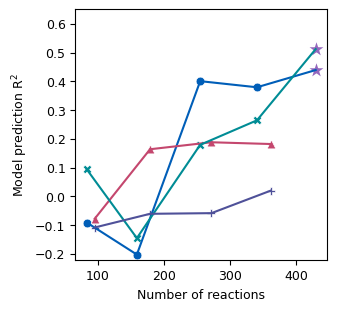

In [49]:
lims = [-0.22, 0.65]
plt.figure(figsize=(3.25, 3.25))
metric = "r2"

sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="AL Base", marker="o", s=40, legend=False)
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random Base", s=40, marker="^", legend=False)
sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=200, legend=False)

sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="AL Expanded", marker="X", s=40)
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random Expanded", marker="P", s=40)
sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=200, label="Expanded set data")


plt.xlabel("Number of reactions")
plt.ylabel(f"Model prediction R$^2$")
plt.ylim(lims)
#plt.legend(prop={"size": 11})
#plt.legend()
plt.legend([],[], frameon=False)
#plt.show()

plt.savefig("images/bybatch_r2.png", dpi=300, bbox_inches="tight")

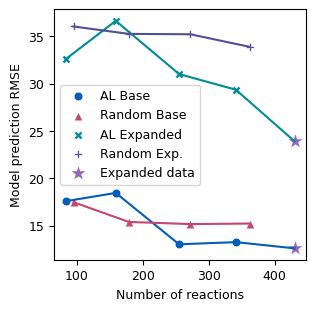

In [50]:
plt.figure(figsize=(3.25, 3.25))
metric = "rmse"

sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, marker="o", s=40, legend=False, label="AL Base")
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, s=40, marker="^", legend=False, label="Random Base")
sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=200, legend=False)

sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, marker="X", s=40, label="AL Expanded")
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, marker="P", s=40, label="Random Exp.")
sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=200, label="Expanded data")

plt.xlabel("Number of reactions")
plt.ylabel("Model prediction RMSE")
plt.legend()

#plt.show()

plt.savefig("images/bybatch_rmse.png", dpi=300, bbox_inches="tight")

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

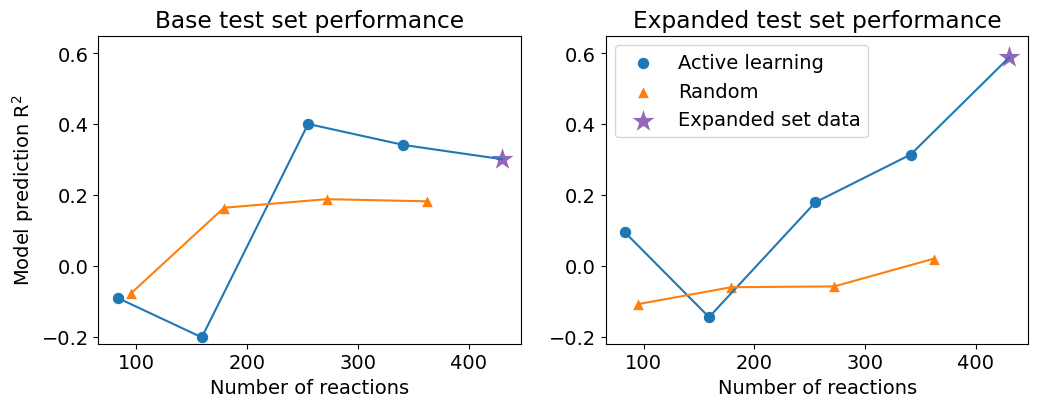

In [27]:
# plot R2 and RMSE by batch for both test sets
lims = [-0.22, 0.65]
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
metric = "r2"
sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", s=80, legend=False)

sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", s=80, marker="^", legend=False)

sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Core 2 data", legend=False)
plt.xlabel("Number of reactions")
plt.ylabel(f"Model prediction R$^2$")
plt.title("Base test set performance")
plt.ylim(lims)
#plt.legend()

plt.subplot(1, 2, 2)
#sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o")
#sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^")

sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", s=80)
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", s=80)

sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data")
plt.title("Expanded test set performance")

plt.xlabel("Number of reactions")
plt.ylabel('')
#plt.legend(loc=(1.1, 0.35))
#plt.legend()
plt.ylim(lims)
plt.show()

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

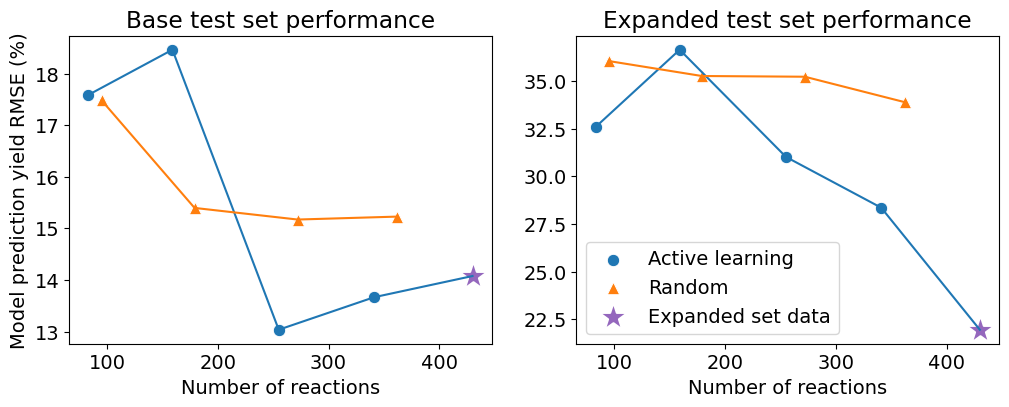

In [28]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
metric = "rmse"
sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, legend=False)
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, legend=False)

sns.scatterplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", s=80, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", s=80, legend=False)

sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data", legend=False)
plt.xlabel("Number of reactions")
plt.ylabel(f"Model prediction yield RMSE (%)")
plt.title("Base test set performance")

plt.subplot(1, 2, 2)
sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric)
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric)

sns.scatterplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", s=80)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", s=80)

sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data")
plt.title("Expanded test set performance")

plt.xlabel("Number of reactions")
plt.ylabel('')
#plt.legend(loc=(1.1, 0.35))
#plt.legend()
plt.show()

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

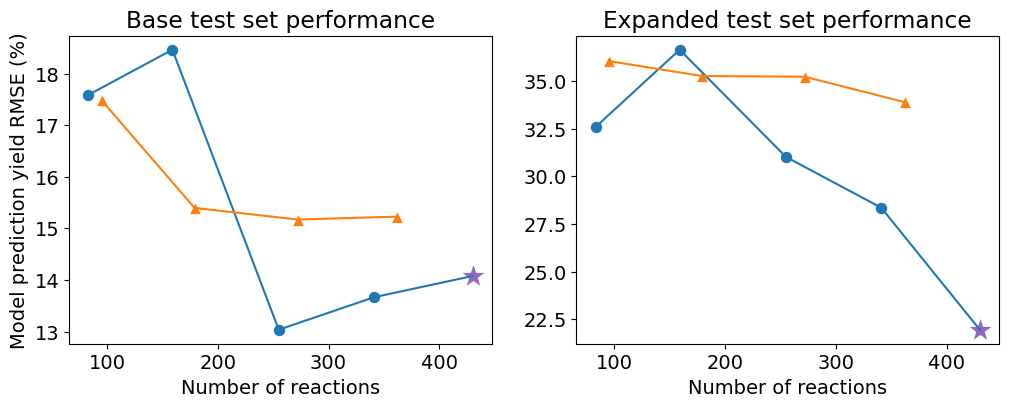

In [29]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
metric = "rmse"
sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, legend=False)
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, legend=False)

sns.scatterplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", s=80, legend=False)
sns.scatterplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", s=80, legend=False)

sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data", legend=False)
plt.xlabel("Number of reactions")
plt.ylabel(f"Model prediction yield RMSE (%)")
plt.title("Base test set performance")

plt.subplot(1, 2, 2)
sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, legend=False)
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, legend=False)

sns.scatterplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", s=80, legend=False)
sns.scatterplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", s=80, legend=False)

sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data", legend=False)
plt.title("Expanded test set performance")

plt.xlabel("Number of reactions")
plt.ylabel('')
#plt.legend(loc=(1.1, 0.35))
#plt.legend()
plt.show()

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

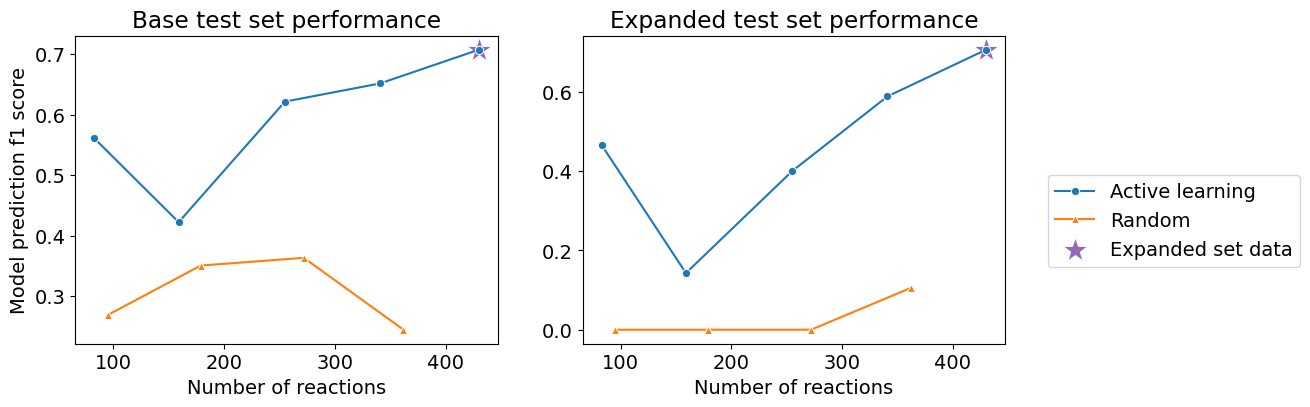

In [30]:
# plot f1 and prc-auc at threshold 20 by batch for both test sets

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
metric = "20_f1"
sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", legend=False)
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", legend=False)
sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data", legend=False)
plt.xlabel("Number of reactions")
plt.ylabel(f"Model prediction f1 score")
plt.title("Base test set performance")

plt.subplot(1, 2, 2)
sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o")
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^")
sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data")
plt.title("Expanded test set performance")

plt.xlabel("Number of reactions")
plt.ylabel('')
plt.legend(loc=(1.1, 0.25))
plt.show()

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

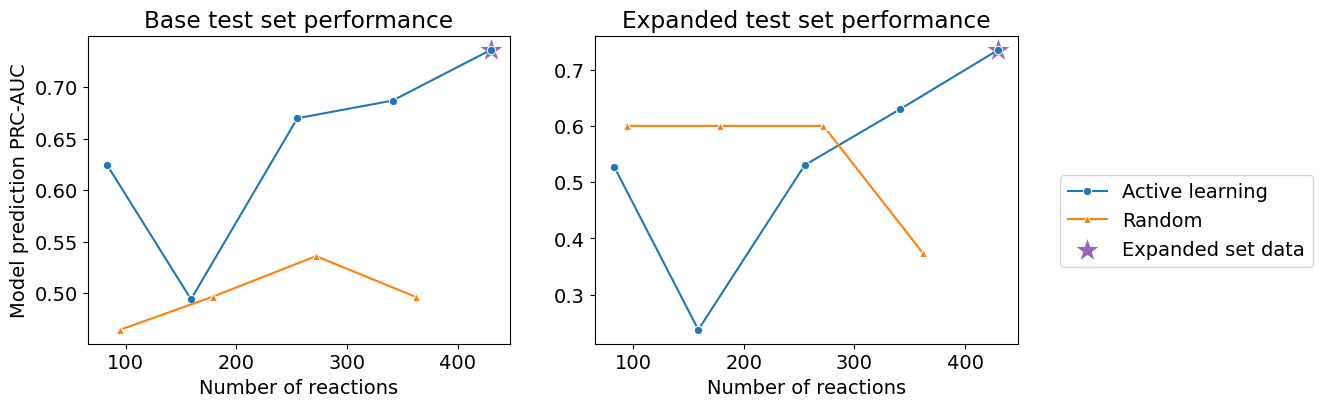

In [31]:

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
metric = "20_prc-auc"
sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", legend=False)
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", legend=False)
sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data", legend=False)
plt.xlabel("Number of reactions")
plt.ylabel(f"Model prediction PRC-AUC")
plt.title("Base test set performance")

plt.subplot(1, 2, 2)
sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o")
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^")
sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data")
plt.title("Expanded test set performance")

plt.xlabel("Number of reactions")
plt.ylabel('')
plt.legend(loc=(1.1, 0.25))
plt.show()

/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rickena1/.conda/envs/chemutils/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

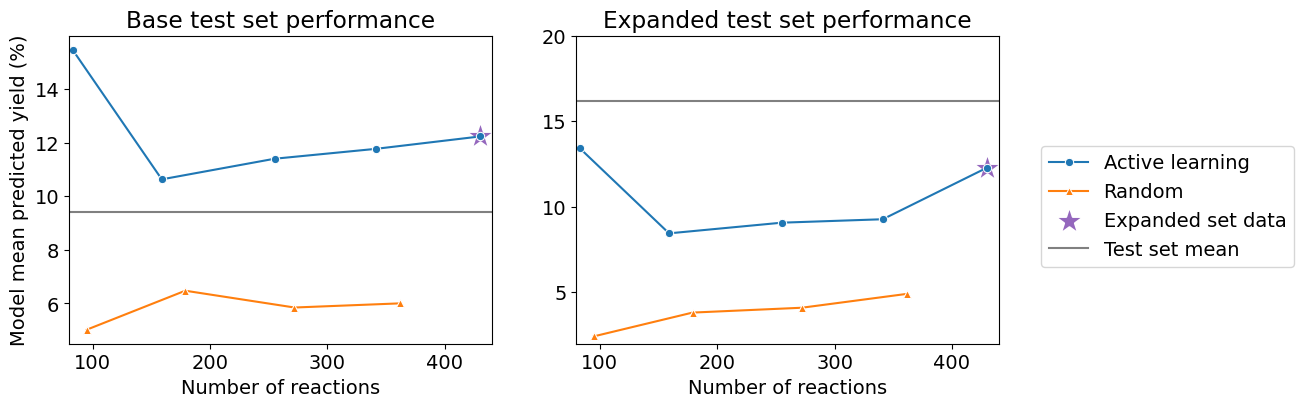

In [32]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
xlims = [80,440]
test1_mean = df_test_core1[target].mean()
test2_mean = df_test_core2[target].mean()
metric = "mean"
sns.lineplot(data=df1[df1["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o", legend=False)
sns.lineplot(data=df1[df1["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^", legend=False)
sns.scatterplot(data=df1[df1.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data", legend=False)
plt.plot(xlims, [test1_mean, test1_mean], c="gray", label="Test set mean")
plt.xlabel("Number of reactions")
plt.ylabel(f"Model mean predicted yield (%)")
plt.title("Base test set performance")
plt.xlim(xlims)

plt.subplot(1, 2, 2)
sns.lineplot(data=df2[df2["Selection strategy"] == "Active learning"], x="num_data", y=metric, label="Active learning", marker="o")
sns.lineplot(data=df2[df2["Selection strategy"] == "Random"], x="num_data", y=metric, label="Random", marker="^")
sns.scatterplot(data=df2[df2.index == "cores2_active_learning"], x='num_data', y=metric, marker='*', color='tab:purple', s=500, label="Expanded set data")
plt.plot(xlims, [test2_mean, test2_mean], c="gray", label="Test set mean")
plt.title("Expanded test set performance")

plt.xlabel("Number of reactions")
plt.ylabel('')
plt.legend(loc=(1.1, 0.25))
plt.xlim(xlims)
plt.ylim([2,20])
plt.show()

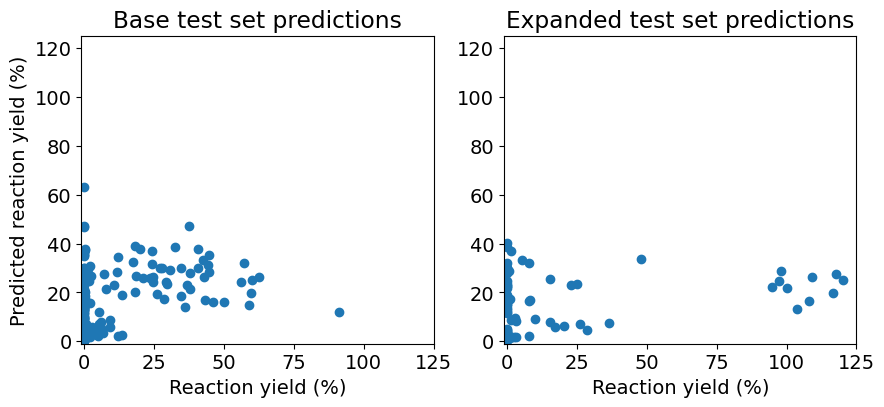

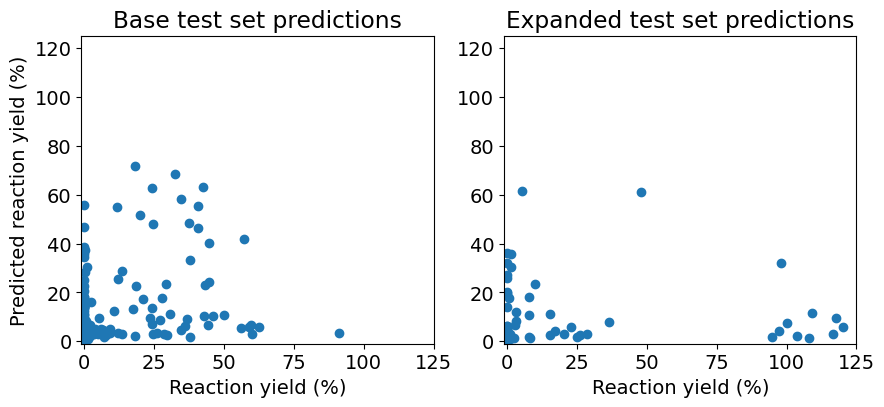

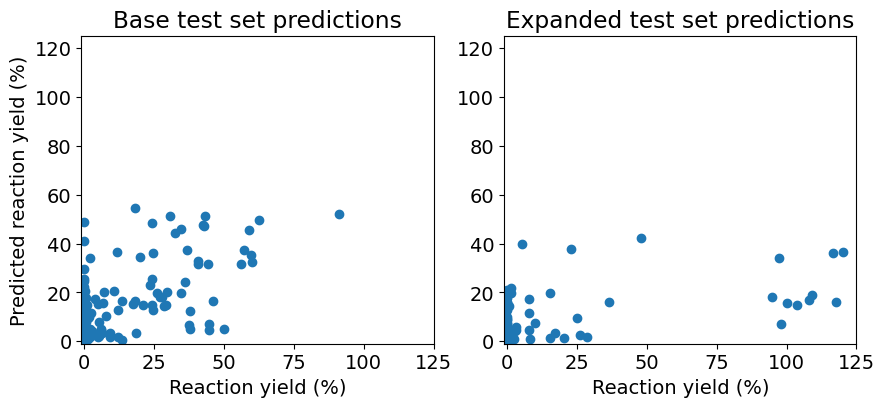

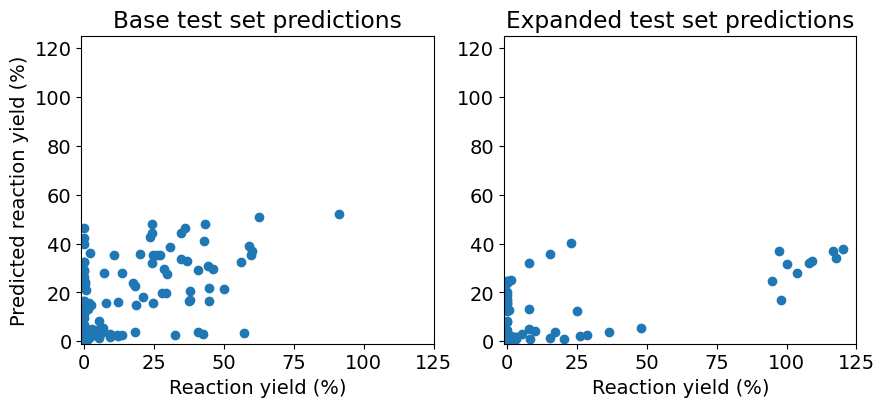

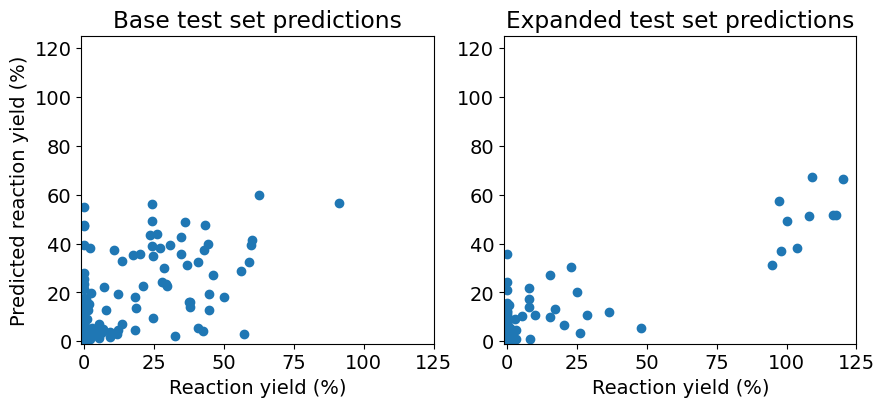

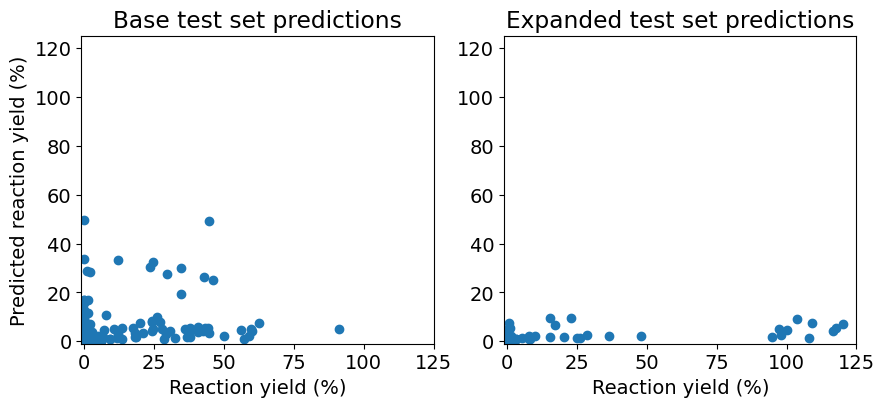

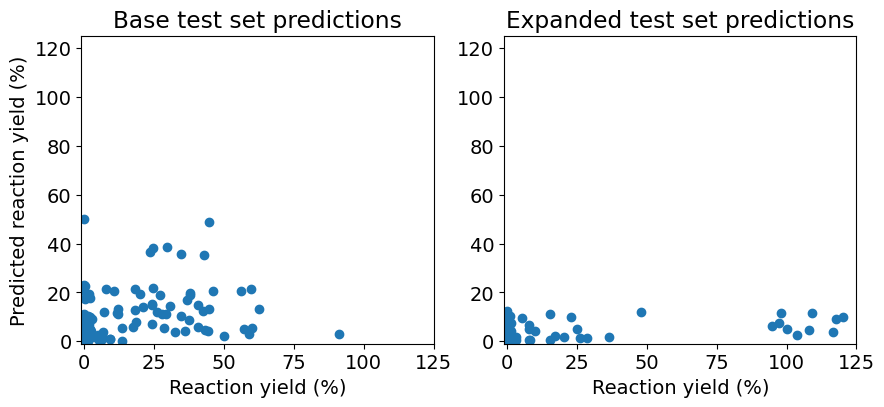

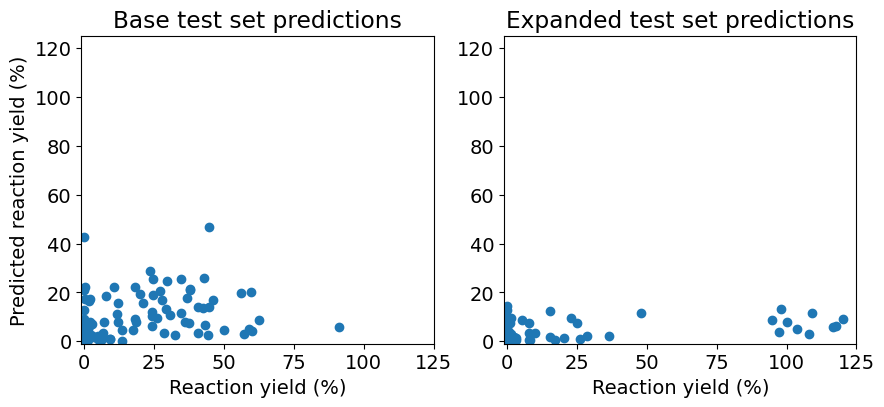

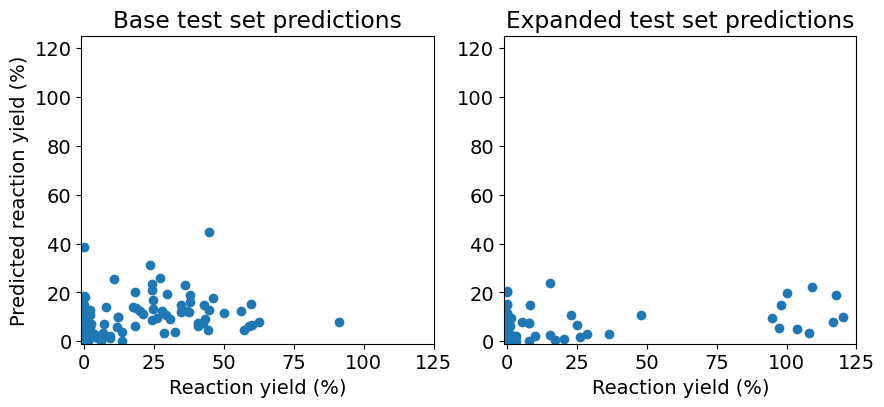

In [30]:
# scatter plots of model yield predictions for SI
lims = [-1,125]

for name in model_names:
    plt.subplots(1, 2, figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(df_test_core1[target], predictions1[name])
    #sns.jointplot(x=df_test_core1[target], y=predictions1[name], kind="hex")
    plt.xlabel("Reaction yield (%)")
    plt.ylabel("Predicted reaction yield (%)")
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title("Base test set predictions")
    plt.subplot(1, 2, 2)
    plt.scatter(df_test_core2[target], predictions2[name])
    #sns.jointplot(x=df_test_core2[target], y=predictions2[name], kind="hex")
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel("Reaction yield (%)")
    #plt.ylabel("Predicted reaction yield (%)")
    plt.title("Expanded test set predictions")

    plt.savefig("images/bybatch_predictions_%s.png" % name, bbox_inches="tight")
plt.show()

* after all data is collected we could theoretically do hyperparameter optimization, so it wouldn't be necessary to use exact same models
* so only need to generate the "by batch" plots here that were trained on all features

maybe in another notebook could do hyperparameter optimization on whole dataset, and ask questions about 
* importance of yield thresholds
* feature ablation
* effect of merging AL and random data